# UNET

 - UNet — Line by Line Explanation: https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5
 - Learn How to Train U-Net On Your Dataset: https://medium.com/coinmonks/learn-how-to-train-u-net-on-your-dataset-8e3f89fbd623
 - Implementation of deep learning framework -- Unet, using Keras: https://github.com/zhixuhao/unet
 - Semantic segmentation with U-Net- train, and test on your custom data in Keras: https://medium.com/@pallawi.ds/semantic-segmentation-with-u-net-train-and-test-on-your-custom-data-in-keras-39e4f972ec89

In [2]:
import os

import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

import glob
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Reshape, UpSampling2D
from keras.layers.core import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.optimizers import Adam

from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [3]:
TRAIN_PATH  = os.path.join(os.getcwd(), 'data', 'train')
MODELS_PATH = os.path.join(os.getcwd(), 'models')

IMG_WIDTH    = 256
IMG_HEIGHT   = 256
IMG_CHANNELS = 3

SEED             = 1
VALIDATION_SPLIT = 0.1
BATCH_SIZE       = 16
STEPS_PER_EPOCH  = 1
EPOCHS           = 2

## Data Augmentation

 - Keras Documentation - ImageDataGenerator class: https://keras.io/preprocessing/image/

In [4]:
data_gen_args = dict(rotation_range=20,
                     zoom_range=0.15,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     shear_range=0.15,
                     horizontal_flip=True,
                     fill_mode='reflect',
                     validation_split=VALIDATION_SPLIT)

mask_data_gen = ImageDataGenerator(**data_gen_args)

data_gen_args['brightness_range'] = (0.6, 1.4) # we don't want to apply brightness to masks
image_data_gen = ImageDataGenerator(**data_gen_args)

flow_args = dict(directory=TRAIN_PATH,
                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                 class_mode=None,
                 batch_size=BATCH_SIZE,
                 seed=SEED)

train_image_gen = image_data_gen.flow_from_directory(**flow_args,
                                                     classes=['images'],
                                                     subset='training')
train_mask_gen = mask_data_gen.flow_from_directory(**flow_args,
                                                   classes=['masks'],
                                                   color_mode='grayscale',
                                                   subset='training')

validation_image_gen = image_data_gen.flow_from_directory(**flow_args,
                                                          classes=['images'],
                                                          subset='validation')
validation_mask_gen = mask_data_gen.flow_from_directory(**flow_args,
                                                        classes=['masks'],
                                                        color_mode='grayscale',
                                                        subset='validation')

Found 27 images belonging to 1 classes.
Found 27 images belonging to 1 classes.
Found 3 images belonging to 1 classes.
Found 3 images belonging to 1 classes.


In [5]:
def training_gen():
    while True:
        for img, mask in zip(train_image_gen, train_mask_gen):
            img = img / 255
            mask = mask / 255
            mask[mask > 0.5] = 1
            mask[mask <= 0.5] = 0
            yield img, mask
            
def validation_gen():
    while True:
        for img, mask in zip(validation_image_gen, validation_mask_gen):
            img = img / 255
            mask = mask / 255
            mask[mask > 0.5] = 1
            mask[mask <= 0.5] = 0
            yield img, mask

### Test data augmentation

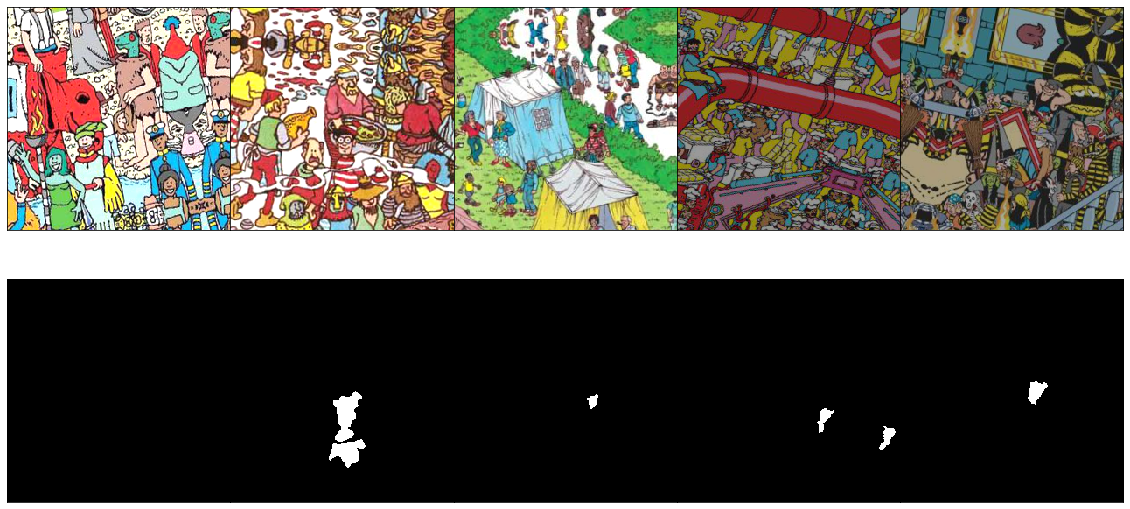

In [6]:
f, axes = plt.subplots(2, 5, figsize=(20,10))
for i in range(5):
    img, mask = next(training_gen())
    
    axes[0,i].imshow((img[0] * 255).astype('uint8'))
    
    mask = (mask[0] * 255)[:,:,0]
    axes[1,i].imshow(mask.astype('uint8'), cmap='gray')
    
    axes[0,i].get_xaxis().set_visible(False)
    axes[0,i].get_yaxis().set_visible(False)
    axes[1,i].get_xaxis().set_visible(False)
    axes[1,i].get_yaxis().set_visible(False)
    
plt.subplots_adjust(wspace=0, hspace=0)

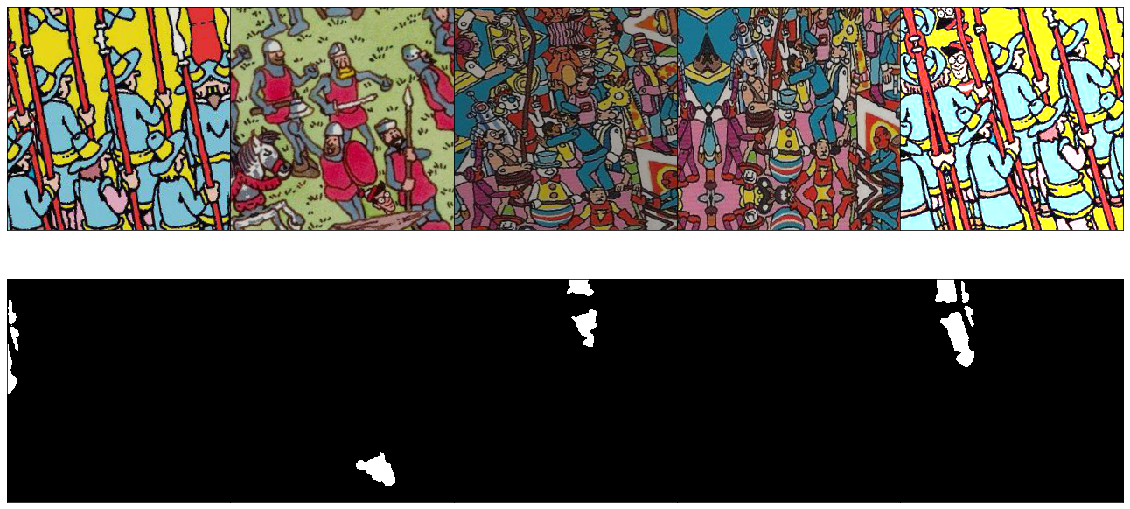

In [7]:
f, axes = plt.subplots(2, 5, figsize=(20,10))
for i in range(5):
    img, mask = next(validation_gen())
    
    axes[0,i].imshow((img[0] * 255).astype('uint8'))
    
    mask = (mask[0] * 255)[:,:,0]
    axes[1,i].imshow(mask.astype('uint8'), cmap='gray')
    
    axes[0,i].get_xaxis().set_visible(False)
    axes[0,i].get_yaxis().set_visible(False)
    axes[1,i].get_xaxis().set_visible(False)
    axes[1,i].get_yaxis().set_visible(False)
    
plt.subplots_adjust(wspace=0, hspace=0)

## Model definition

In [5]:
def unet(pretrained_weights=None):
    """
    Create model for Unet network using keras.
    
    Parameters
    ----------
    pretrained_weights : str
        The HDF5 file path with pretrained weights; default: None.
    
    Returns
    -------
    keras.engine.training.Model
        Returns the Unet model created with keras.
    """
    
    inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
    
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    if pretrained_weights:
        model.load_weights(pretrained_weights)

    return model

In [8]:
unet().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_25[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_26[0][0]                  
__________________________________________________________________________________________________
conv2d_27 

## Training

In [8]:
model = unet()

earlystopper = EarlyStopping(monitor='loss',
                             patience=5,
                             verbose=1)

name = 'unet-b%d-s%d-e%d.{epoch:02d}.hdf5' % (BATCH_SIZE, STEPS_PER_EPOCH, EPOCHS)
checkpointer = ModelCheckpoint(os.path.join(MODELS_PATH, name),
                               monitor='val_acc',
                               save_best_only=True,
                               save_weights_only=False,
                               mode='max',
                               verbose=1)

tensorboard = TensorBoard(log_dir='logs')

In [9]:
model.fit_generator(training_gen(),
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=EPOCHS,
                    callbacks=[earlystopper, checkpointer, tensorboard],
                    validation_data=validation_gen(),
                    validation_steps=2)



Epoch 1/2
1/1 [==============================] - 60s 60s/step - loss: 0.6614 - acc: 0.9810 - val_loss: 0.5980 - val_acc: 0.9886

Epoch 00001: val_acc improved from -inf to 0.98863, saving model to /home/franksacco/Projects/where-is-wally/models/unet-b16-s1-e2.01.hdf5
Epoch 2/2
1/1 [==============================] - 41s 41s/step - loss: 0.5893 - acc: 0.9913 - val_loss: 0.5235 - val_acc: 0.9850

Epoch 00002: val_acc did not improve from 0.98863


## Testing

In [12]:
model = unet('models/unet-b16-s32-e20.11.hdf5')

img = load_img(os.path.join(TRAIN_PATH, 'images', '01_image_2_2.jpg'),
               target_size=(IMG_HEIGHT, IMG_WIDTH))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255

result = model.predict(x)[0]

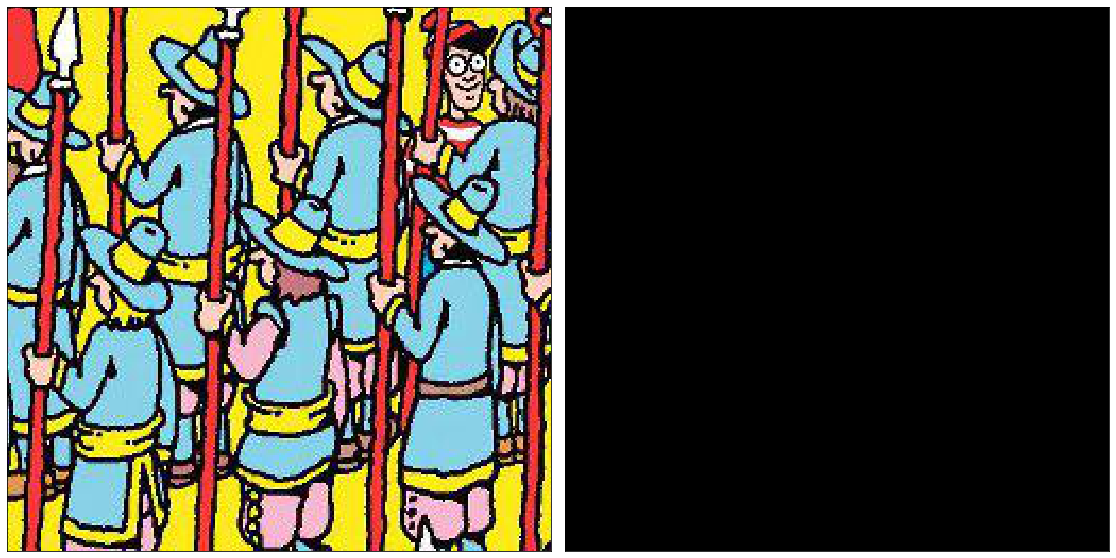

In [13]:
f, axes = plt.subplots(1, 2, figsize=(20,10))

axes[0].imshow(img)

mask = result[:,:,0]
mask[mask > 0.5] = 255
mask[mask <= 0.5] = 0
axes[1].imshow(mask.astype('uint8'), cmap='gray')

axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)

plt.subplots_adjust(wspace=0, hspace=0)